# City footprint

This notebook explores how to make a footprint measure of cities, taking a dataset of:
* 200 cities around the world, with populations metadata.
* Hyperspectral data for several cities, a subset of the 200 cities, and others around them.
* Landsat and Hyperion were available.

This notebook:
* [Plots basic information and maps of the dataset](#Plot-a-map-and-basic-info-from-the-cities-dataset)
* Load an example city:
    * [from Landsat](#Load-example-city-from-Landsat)
    * from macro Satellogic
    * from hyperion

# Plot a map and basic info from the cities dataset

In [2]:
import os
# Set Mapbox Access Token to create visual.  https://www.mapbox.com/account/access-tokens
token = "pk.eyJ1IjoiYnJ1bm9zYW4iLCJhIjoic3FUc1dJWSJ9.v0525WacYWcsHM1KtbZitg"
print("Mapbox token is:",token)

Mapbox token is: pk.eyJ1IjoiYnJ1bm9zYW4iLCJhIjoic3FUc1dJWSJ9.v0525WacYWcsHM1KtbZitg


In [3]:
from mapboxgl.viz import *
from mapboxgl.utils import *
import pandas as pd

# Load data from csv
data_url = 'https://gist.githubusercontent.com/brunosan/52058909cb5fda0c6830c32c10f47698/raw/369bc0f60cde72d982c7e056aa2db402896a973a/cities.csv'
df = pd.read_csv(data_url,header=0 )

# Create geojson data object
df_to_geojson(
      df,
      filename="cdec.geojson",
      precision=4
) 

df.head(2)

,Country Name,City Name,lat,lon,Population 1990,Population 2000,Population 2010,%Growth Rate 1990-2001,%Growth Rate 2000-2011,Source
0,Afghanistan,Kabul,34.5289,69.1725,1549320,2401109.0,3722320,4.38,4.38,UN Population Division
1,Algeria,Algiers,36.7525,3.0420,1797068,2140577.0,2432023,1.75,1.28,UN Population Division


In [4]:
#plot interactive map

import pysal.esda.mapclassify as mapclassify
# Generate data breaks and color stops from colorBrewer
color_breaks = mapclassify.Natural_Breaks(df['%Growth Rate 2000-2011'], k=8, initial=0).bins
color_stops = create_color_stops(color_breaks, colors='RdYlGn')

# Generate radius breaks from data domain and circle-radius range
radius_breaks = mapclassify.Natural_Breaks(df["Population 2010"], k=8, initial=0).bins
radius_stops = create_radius_stops(radius_breaks, 3, 10)

# Create the viz from the dataframe
viz = GraduatedCircleViz('cdec.geojson',
                access_token=token, 
                height='400px',
                color_property = "%Growth Rate 2000-2011",
                color_stops = color_stops,
                radius_property = "Population 2010",
                radius_stops = radius_stops,
                center = (0, 0),
                zoom = 1,
                below_layer = 'waterway-label')

viz.show()

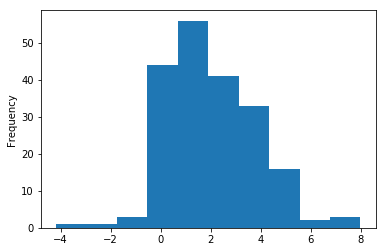

In [7]:
#Another example plot, histogram of the growth rate, per city.
df['%Growth Rate 2000-2011'].plot.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bba8160>,
      dtype=object)

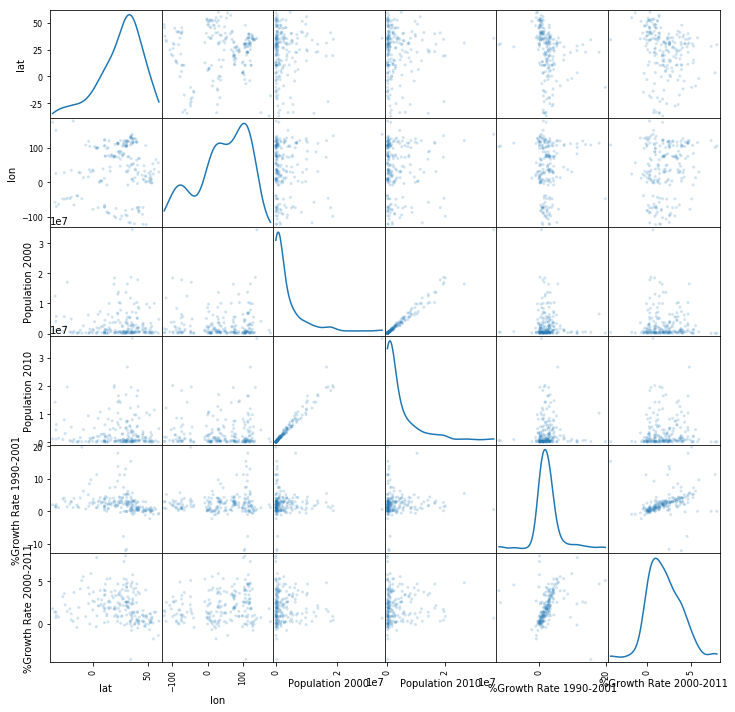

In [8]:
#last example visualization
#Scatterplot of each parameter against others, and the kernel (~histogram) in the diagonal
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde')

# Load example city from Landsat


In [ ]:
#TODO